# Exploratory Data Analysis of Dataset

<h3>About dataset</h3>

# Amazon Fine Food Reviews


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


# Objective:

Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<h3>[Q] How to determine if a review is positive or negative?</h3>

#### 1.Naive Way

We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

We can use this Score/Rating variable to determine class lable of test data

#### 2. Using review text to decide the polarity
For this we will perform Natural Language Processing related tasks. We will take the review text, build a Machine Learning model on top of it and predict if new(future) reviews are positive or negative.

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Loading the dataset

In [2]:
#Using sqlite3 to retrieve data from sqlite file
conn = sqlite3.connect('database.sqlite') # Sql connection object

#Using pandas functions to query from sql table
df_amazon = pd.read_sql_query("""SELECT * FROM Reviews """,conn)
df_amazon.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 1. Analysing the Data (High level statistics of the dataset)

In [3]:
# (Q) how many data-points and features?
print (df_amazon.shape)

(568454, 10)


In [4]:
#(Q) What are the column names in our dataset?
print (df_amazon.columns)

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [5]:
print("Number of datapoints: ",df_amazon.shape[0])
print("Number of features: ",df_amazon.shape[1])

Number of datapoints:  568454
Number of features:  10


In [6]:
# Checking wether data has any missing values

print(df_amazon.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None


Observation:

Dataset doen't have any missing values. So no need to handle missing data

In [7]:
## No-of data points/reviews for which no user indicated whether they found the review helpful or not
#HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

df_amazon[df_amazon.HelpfulnessDenominator == 0].shape

(270052, 10)

#### Number of reviews which does not have any upvote

In [8]:
print("Number of reviews which does not have any upvote: ",df_amazon[df_amazon.HelpfulnessDenominator==0].shape[0])

Number of reviews which does not have any upvote:  270052


#### Total number of unique users

In [15]:
print("Total number of unique users: ",len(set(list(df_amazon.UserId))))

Total number of unique users:  256059


#### Total number of unique products

In [12]:

print("Total number of unique products: ",len(set(list(df_amazon.ProductId))))

Total number of unique products:  74258


# 2. Statistical analysis using Mean,STD,and Percentiles

In [13]:
#Breif description about the dataset
#Get Mean/Median/Percentile/Standard Deviation information 
df_amazon.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


### 3. Number of reviews corresponding to each of the ratings.

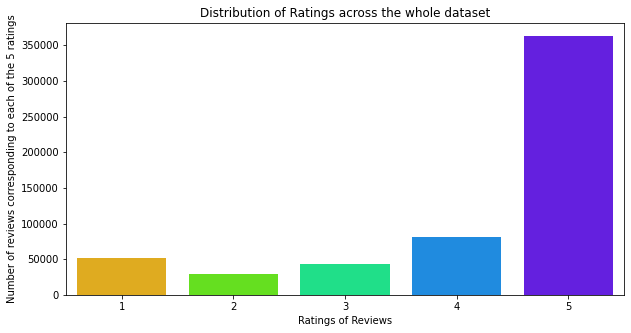

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64


In [14]:
plt.figure(figsize=(10,5))
sns.countplot(df_amazon['Score'], palette='gist_rainbow')
plt.title("Distribution of Ratings across the whole dataset")
plt.xlabel("Ratings of Reviews")
plt.ylabel("Number of reviews corresponding to each of the 5 ratings")
plt.show()

print(df_amazon['Score'].value_counts())

Observation:

Here, we can see that 63.8% reviews have rating equal to 5, 14.1% reviews have rating equal to 4, 7.5% reviews have rating equal to 3, 5.2% revies have ratings equal to 2 and lastly 9.1% reviews have ratings equal to 1. This shows that most of the reviews that are there in the dataset has a very high rating of 5 (almost 64%, that's massive!). The next most prevalent rating is 4-stars(14%), followed by 1-star (9%), 3-star (7%), and finally 2-star reviews (5%). So, going by the naive approach we can clearly see that almost 78% of the reviews are positive! This means most users who has purchased goods from Amazon are very satified with their purchase!

For further analysis and for modeling we have to make the dataset ready.In order to that we need to perform the following three
steps

1) Data cleaning

2) Data Preprocessing

3) Make the data ready for modeling with independant and dependant vriables
